In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [3]:
edu = pd.read_csv('/Users/Vi/Documents/qbus6860/group/Education-services-au-export.csv',na_values=['np','unknown'])
edu.head()

,ServiceApprovalNumber,Provider Approval Number,ServiceName,ProviderLegalName,ServiceType,ServiceAddress,Suburb,State,Postcode,Phone,...,Holiday Care Wednesday End Time,Holiday Care Thursday Start Time,Holiday Care Thursday End Time,Holiday Care Friday Start Time,Holiday Care Friday End Time,Holiday Care Saturday Start Time,Holiday Care Saturday End Time,Holiday Care Sunday Start Time,Holiday Care Sunday End Time,Temporarily Closed
0,SE-00000002,PR-00000898,Community Kids Waterford Early Education Centre,G8 Education Limited,Centre-Based Care,8-10 Allora St,WATERFORD WEST,QLD,4133.0,0732009852,...,18:15,06:15,18:15,06:15,18:15,NaN,NaN,NaN,NaN,No
1,SE-00000003,PR-40029099,KIDVENTURE EARLY LEARNING EAGLEBY,Table Mountain Trading Pty Ltd As The Trustee ...,Centre-Based Care,82 Fryar Road,EAGLEBY,QLD,4207.0,0738073222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,SE-00000004,PR-00000898,Community Kids - Broadbeach Waters,G8 Education Limited,Centre-Based Care,4 Fremar Street,BROADBEACH WATERS,QLD,4217.0,0755920306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,SE-00000005,PR-40002184,Little Scholars School of Early Learning Burle...,The Scholars Group Pty Ltd,Centre-Based Care,143 Christine Ave,BURLEIGH WATERS,QLD,4220.0,0755353288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4,SE-00000006,PR-40029104,Small World Child Care Centre,A. & K. Massouras Pty. Ltd. ATF The A Massoura...,Centre-Based Care,113-115 Pappas Way,CARRARA,QLD,4211.0,07 5594 1844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [6]:
seifa_path = pd.ExcelFile('/Users/Vi/Documents/qbus6860/group/Local Government Area, Indexes, SEIFA 2021.xlsx')
sheet_name = 'Table 2'
seifa_2021 = pd.read_excel(seifa_path,sheet_name = 'Table 2',skiprows = 5)
seifa_2021 = seifa_2021.drop(seifa_2021.columns[4],axis=1)
seifa_2021 = seifa_2021.drop(seifa_2021.columns[5:],axis=1)
seifa_2021 = seifa_2021.drop(index=seifa_2021.index[549])

seifa_2021 = seifa_2021.dropna(how='all')
seifa_2021 = seifa_2021.reset_index(drop=True)
seifa_2021.columns = ['Code','Name','Population','Score','Rank']
seifa_2021

,Code,Name,Population,Score,Rank
0,10050,Albury,56093.0,967.904028,232.0
1,10180,Armidale Regional,29124.0,980.361546,281.0
2,10250,Ballina,46296.0,1015.142657,411.0
3,10300,Balranald,2208.0,960.162516,200.0
4,10470,Bathurst Regional,43567.0,991.494086,330.0
...,...,...,...,...,...
542,74660,West Arnhem,6281.0,530.386225,13.0
543,74680,West Daly,2973.0,439.482988,1.0
544,79399,Unincorporated NT,6802.0,1043.653061,480.0
545,89399,Unincorporated ACT,453890.0,1070.922935,514.0


In [7]:
seifa_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Code        547 non-null    object 
 1   Name        547 non-null    object 
 2   Population  547 non-null    float64
 3   Score       547 non-null    float64
 4   Rank        547 non-null    float64
dtypes: float64(3), object(2)
memory usage: 21.5+ KB


In [10]:
aedc = '/Users/Vi/Desktop/usyd/qbus6860/DATA/LGA 2009-21(AEDC).xlsx'
sheet_name = 'aedc_2021'
aedc_2021 = pd.read_excel(aedc,sheet_name = 'aedc_2021')

remove_state = ['New South Wales','Victoria','Queensland',
               'Western Australia','South Australia',
               'Tasmania','Australian Capital Territory','Northern Territory']
aedc_2021 = aedc_2021[~aedc_2021['Code'].astype(str).isin(remove_state)]
               
aedc_2021 = aedc_2021.dropna(how='all')
aedc_2021 = aedc_2021.reset_index(drop=True)
aedc_2021.columns = ['Code','Name','2021Score','2021dv2n','2021dv2p']


aedc_2021

,Code,Name,2021Score,2021dv2n,2021dv2p
0,10050,Albury,648,89,13.734568
1,10180,Armidale Regional,307,42,13.680782
2,10250,Ballina,402,36,8.955224
3,10300,Balranald,17,5,29.411765
4,10470,Bathurst Regional,513,82,15.984405
...,...,...,...,...,...
543,74560,Wagait,4,*,*
544,74660,West Arnhem,68,*,*
545,74680,West Daly,59,31,52.542373
546,79399,Unincorporated NT,80,8,10


In [11]:
aedc_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Code       548 non-null    object
 1   Name       548 non-null    object
 2   2021Score  548 non-null    object
 3   2021dv2n   548 non-null    object
 4   2021dv2p   548 non-null    object
dtypes: object(5)
memory usage: 21.5+ KB


In [12]:
cols = ['2021Score', '2021dv2n', '2021dv2p']
aedc_2021[cols].head()
aedc_2021[cols].dtypes

for c in cols:
    aedc_2021[c] = aedc_2021[c].astype(str).str.strip()
    
for c in cols:
    aedc_2021[c] = aedc_2021[c].astype(str).str.strip()
    
aedc_2021['2021dv2p'] = aedc_2021['2021dv2p'].str.replace('%', '', regex=False)

for c in cols:
    aedc_2021[c] = pd.to_numeric(aedc_2021[c], errors='coerce')  # 把无法转换的置为 NaN
    
print(aedc_2021[cols].dtypes)
print(aedc_2021[cols].head())

2021Score    float64
2021dv2n     float64
2021dv2p     float64
dtype: object
   2021Score  2021dv2n   2021dv2p
0      648.0      89.0  13.734568
1      307.0      42.0  13.680782
2      402.0      36.0   8.955224
3       17.0       5.0  29.411765
4      513.0      82.0  15.984405


In [13]:
aedc_2021['Name_clean'] = aedc_2021['Name'].str.lower().str.strip()

In [14]:
seifa_2021['Name_clean'] = seifa_2021['Name'].str.lower().str.strip()
aedc_seifa_2021 = pd.merge(aedc_2021,seifa_2021[['Name_clean','Score','Population','Rank']],
                                   on = 'Name_clean',
                                   how = 'left')
aedc_seifa_2021

,Code,Name,2021Score,2021dv2n,2021dv2p,Name_clean,Score,Population,Rank
0,10050,Albury,648.0,89.0,13.734568,albury,967.904028,56093.0,232.0
1,10180,Armidale Regional,307.0,42.0,13.680782,armidale regional,980.361546,29124.0,281.0
2,10250,Ballina,402.0,36.0,8.955224,ballina,1015.142657,46296.0,411.0
3,10300,Balranald,17.0,5.0,29.411765,balranald,960.162516,2208.0,200.0
4,10470,Bathurst Regional,513.0,82.0,15.984405,bathurst regional,991.494086,43567.0,330.0
...,...,...,...,...,...,...,...,...,...
543,74560,Wagait,4.0,NaN,NaN,wagait,984.667904,423.0,294.0
544,74660,West Arnhem,68.0,NaN,NaN,west arnhem,530.386225,6281.0,13.0
545,74680,West Daly,59.0,31.0,52.542373,west daly,439.482988,2973.0,1.0
546,79399,Unincorporated NT,80.0,8.0,10.000000,unincorporated nt,1043.653061,6802.0,480.0


In [15]:
edu['NumberOfApprovedPlaces'] = edu['NumberOfApprovedPlaces'].astype(float)

In [16]:
edu['Suburb_clean'] = edu['Suburb'].astype(str).str.strip().str.lower()

In [17]:
seifa_subs= set(aedc_seifa_2021['Name_clean'].dropna().unique())

edu_suburbs = set(edu['Suburb_clean'].dropna().unique())

dv_subs = seifa_subs.intersection(edu_suburbs)

print(f"There are{len(dv_subs)} suburbs in both two dataframs：")
print(sorted(dv_subs))

There are258 suburbs in both two dataframs：
['adelaide', 'albany', 'albury', 'alice springs', 'ararat', 'armadale', 'ashburton', 'aurukun', 'ballarat', 'ballina', 'balranald', 'barcaldine', 'bassendean', 'bayswater', 'bellingen', 'belmont', 'benalla', 'berrigan', 'beverley', 'blacktown', 'blayney', 'boddington', 'bourke', 'boyup brook', 'brewarrina', 'brighton', 'brisbane', 'broken hill', 'brookton', 'broome', 'bruce rock', 'bunbury', 'bundaberg', 'burnie', 'burnside', 'burwood', 'busselton', 'cairns', 'cambridge', 'camden', 'capel', 'cardinia', 'carnamah', 'carnarvon', 'casey', 'ceduna', 'cessnock', 'charters towers', 'cherbourg', 'christmas island', 'claremont', 'cleve', 'cloncurry', 'cobar', 'coffs harbour', 'collie', 'coober pedy', 'coolamon', 'coonamble', 'corrigin', 'cottesloe', 'cowra', 'cranbrook', 'croydon', 'cunderdin', 'dalwallinu', 'dardanup', 'darwin', 'denmark', 'devonport', 'doomadgee', 'douglas', 'dowerin', 'dundas', 'dungog', 'east fremantle', 'elliston', 'esperance', 

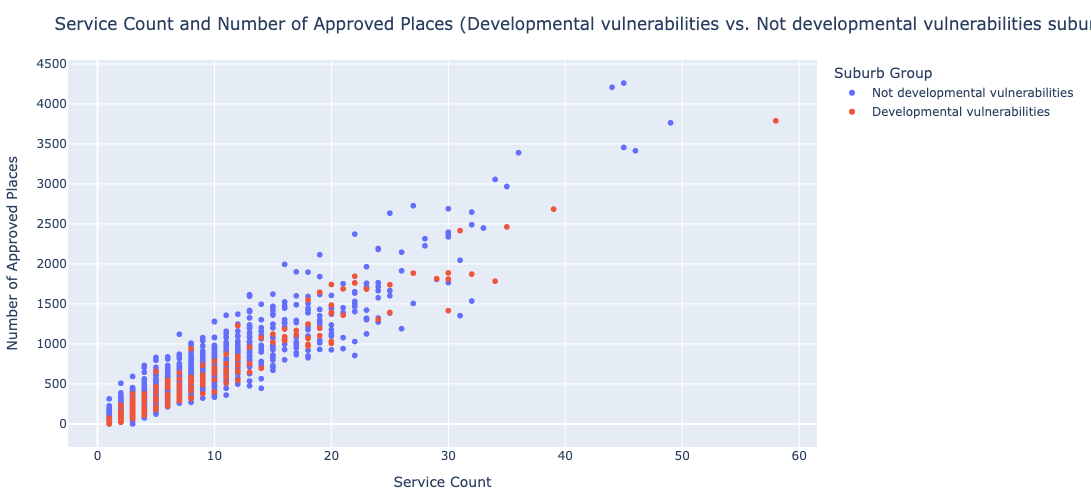

In [18]:
import plotly.express as px

edu_all = edu.groupby('Suburb_clean').agg(
    service_count=('ServiceName', 'nunique'),
    total_Approved_places=('NumberOfApprovedPlaces', 'sum')
).reset_index()

dv_subs = [
    'adelaide', 'albany', 'albury', 'alice springs', 'ararat', 'armadale',
    'ashburton', 'aurukun', 'ballarat', 'ballina', 'balranald', 'barcaldine',
    'bassendean', 'bayswater', 'bellingen', 'belmont', 'benalla', 'berrigan',
    'beverley', 'blacktown', 'blayney', 'boddington', 'bourke', 'boyup brook',
    'brewarrina', 'brighton', 'brisbane', 'broken hill', 'brookton', 'broome',
    'bruce rock', 'bunbury', 'bundaberg', 'burnie', 'burnside', 'burwood',
    'busselton', 'cairns', 'cambridge', 'camden', 'capel', 'cardinia',
    'carnamah', 'carnarvon', 'casey', 'ceduna', 'cessnock', 'charters towers',
    'cherbourg', 'christmas island', 'claremont', 'cleve', 'cloncurry', 'cobar',
    'coffs harbour', 'collie', 'coober pedy', 'coolamon', 'coonamble',
    'corrigin', 'cottesloe', 'cowra', 'cranbrook', 'croydon', 'cunderdin',
    'dalwallinu', 'dardanup', 'darwin', 'denmark', 'devonport', 'doomadgee',
    'douglas', 'dowerin', 'dundas', 'dungog', 'east fremantle', 'elliston',
    'esperance', 'exmouth', 'fairfield', 'forbes', 'frankston', 'fremantle',
    'gawler', 'george town', 'gilgandra', 'gingin', 'gladstone', 'glenelg',
    'glenorchy', 'goomalling', 'goondiwindi', 'gosnells', 'griffith',
    'gunnedah', 'gympie', 'halls creek', 'harvey', 'hay', 'hepburn',
    'hinchinbrook', 'hobart', 'hope vale', 'hornsby', 'horsham', 'hunters hill',
    'inverell', 'ipswich', 'jerramungup', 'joondalup', 'junee', 'kalamunda',
    'karratha', 'katanning', 'katherine', 'kempsey', 'kiama', 'kimba',
    'kojonup', 'kowanyama', 'kulin', 'kyogle', 'lake grace', 'lane cove',
    'launceston', 'laverton', 'leeton', 'leonora', 'lismore', 'lithgow',
    'liverpool', 'lockhart', 'lockhart river', 'longreach', 'mackay',
    'maitland', 'mandurah', 'manjimup', 'manningham', 'mansfield',
    'mapoon', 'mareeba', 'maribyrnong', 'marion', 'melbourne', 'melton',
    'melville', 'merredin', 'mildura', 'mingenew', 'mitcham', 'monash',
    'moora', 'moreland', 'mornington', 'mosman', 'mosman park', 'mount barker',
    'mount gambier', 'mount isa', 'mukinbudin', 'mundaring', 'murchison',
    'murray bridge', 'muswellbrook', 'nannup', 'napranum', 'narembeen',
    'narrabri', 'narrandera', 'narrogin', 'narromine', 'nedlands',
    'newcastle', 'north sydney', 'northam', 'northampton', 'oberon', 'orange',
    'palm island', 'palmerston', 'parkes', 'parramatta', 'penrith',
    'peppermint grove', 'perenjori', 'perth', 'peterborough', 'pormpuraaw',
    'port augusta', 'port hedland', 'port lincoln', 'port pirie', 'prospect',
    'quairading', 'quilpie', 'randwick', 'ravensthorpe', 'richmond', 'robe',
    'rockhampton', 'rockingham', 'roxby downs', 'ryde', 'salisbury',
    'shellharbour', 'singleton', 'somerset', 'sorell', 'south perth',
    'stirling', 'strathfield', 'streaky bay', 'subiaco', 'swan hill', 'sydney',
    'tea tree gully', 'temora', 'tenterfield', 'three springs', 'toodyay',
    'toowoomba', 'townsville', 'tumby bay', 'unley', 'uralla', 'victor harbor',
    'victoria park', 'vincent', 'wagga wagga', 'wagin', 'walcha', 'walgett',
    'walkerville', 'wangaratta', 'wanneroo', 'waroona', 'warren',
    'warrnambool', 'waverley', 'weipa', 'wellington', 'wentworth',
    'whittlesea', 'whyalla', 'williams', 'willoughby', 'winton', 'wodonga',
    'wollongong', 'woollahra', 'woorabinda', 'wudinna', 'wujal wujal',
    'wyndham', 'yankalilla', 'yarrabah', 'york'
]

edu_all['group'] = edu_all['Suburb_clean'].apply(
    lambda x: 'Not developmental vulnerabilities' 
    if x not in dv_subs 
    else 'Developmental vulnerabilities'
)

fig = px.scatter(
    edu_all,
    x='service_count',
    y='total_Approved_places',
    color='group',
    title='Service Count and Number of Approved Places\n(Developmental vulnerabilities vs. Not developmental vulnerabilities suburbs)',
    labels={
        'service_count': 'Service Count',
        'total_Approved_places': 'Number of Approved Places'
    },
    hover_data=['Suburb_clean', 'service_count', 'total_Approved_places'],
    width=900,
    height=500
)

fig.update_layout(
    legend_title_text='Suburb Group',
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()

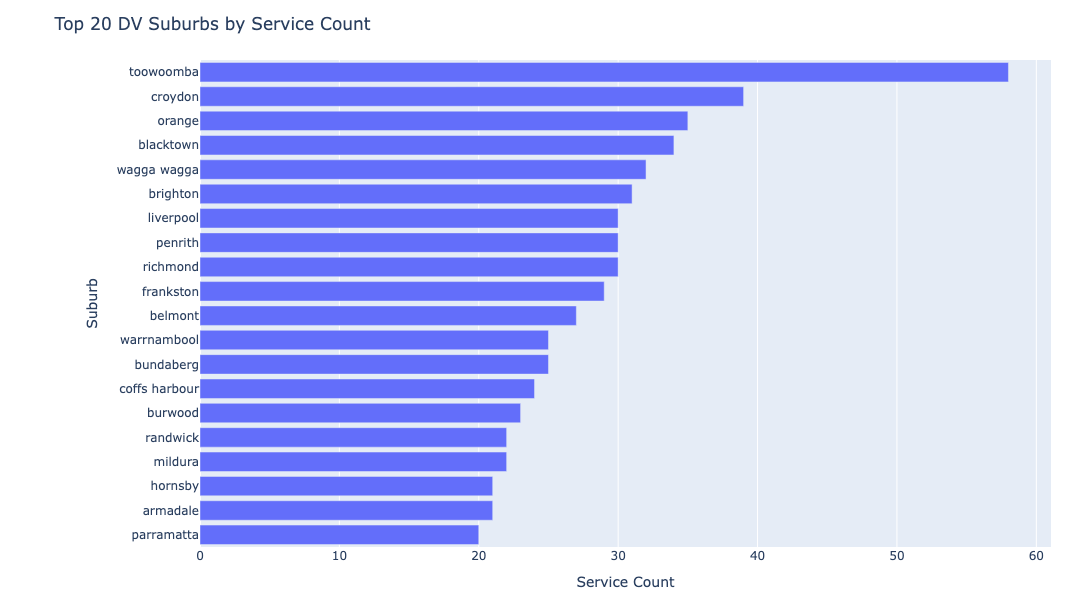

In [19]:
edu_all = (
    edu
    .groupby('Suburb_clean')
    .agg(
        service_count=('ServiceName', 'nunique'),
        total_Approved_places=('NumberOfApprovedPlaces', 'sum')
    )
    .reset_index()
)

dv_data = (
    edu_all[edu_all['Suburb_clean'].isin(dv_subs)]
    .sort_values('service_count', ascending=False)
    .head(20)  
)

fig = px.bar(
    dv_data,
    x='service_count',
    y='Suburb_clean',
    orientation='h',
    title='Top 20 DV Suburbs by Service Count',
    labels={
        'service_count': 'Service Count',
        'Suburb_clean': 'Suburb'
    },
    hover_data=['service_count', 'total_Approved_places'],
    width=900,
    height=600
)

fig.update_layout(
    yaxis=dict(
        categoryorder='total ascending'  
    ),
    margin=dict(l=200, r=40, t=60, b=40)  
)

fig.show()

In [20]:
top20_suburbs = dv_subs[:20]

edu['OverallRating_num'] = pd.to_numeric(edu['OverallRating'], errors='coerce')

top20_states = (
    edu[edu['Suburb_clean'].isin(top20_suburbs)]
    .groupby('Suburb_clean')
    .agg(state=('State', 'first'))
    .reset_index()
)
state_counts = top20_states['state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']
state_counts

,state,count
0,NSW,6
1,VIC,6
2,QLD,3
3,SA,2
4,WA,2
5,NT,1


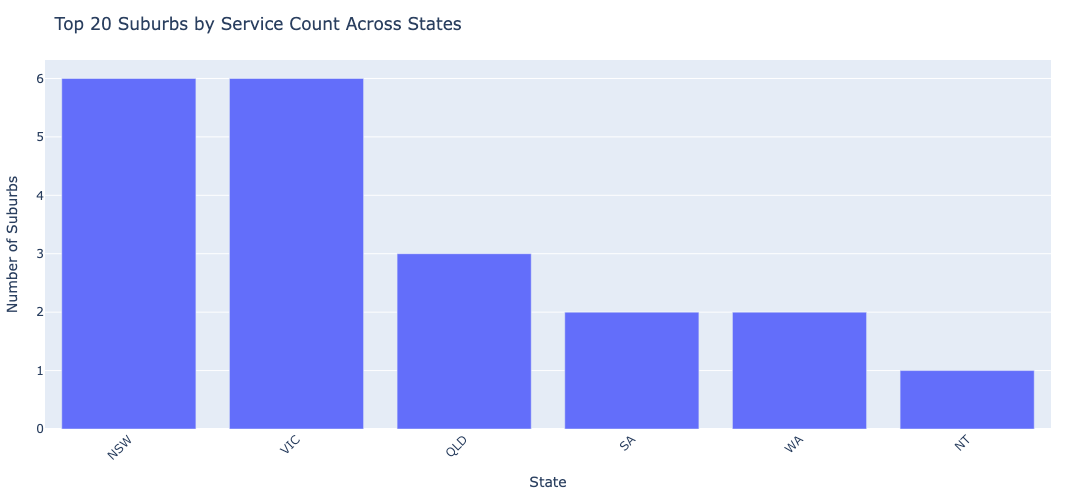

In [21]:
fig = px.bar(
    state_counts,
    x='state',
    y='count',
    title='Top 20 Suburbs by Service Count Across States',
    labels={'state': 'State', 'count': 'Number of Suburbs'},
    width=800,
    height=500
)
fig.update_layout(
    xaxis_tickangle=-45,
    margin=dict(l=40, r=40, t=60, b=40)
)
fig.show()